In [1]:
import ujson
import numpy 
import datetime
import json
from collections import Counter

## 1. Load Data

In [2]:
summaries = {}
ctr = 0
for line in open('user_project_summaries.json'): # lazy iteration because the file is large
    ctr+=1
    summaries.update(ujson.loads(line))  
    print ctr,

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47


In [3]:
from features import *
import features
reload(features)
import sys, os
sys.path.append(os.getcwd())


The languages labels are inferred from the `namestrings_to_langs.py` script using `langid`.

In [4]:
isocodes = ujson.load(open('isocodes.json'))  # mapping from  iso code to language name
user_langs = ujson.load(open('user_inferredlangs.json'))  # mapping from userid to inferred language
# remove uncommon languages
lang_counts = Counter()
for user in user_langs:
    lang = user_langs[user]
    lang_counts[lang] += 1
    
user_langs = {user: lang for user, lang in user_langs.items() if lang_counts[lang]>=250 and user in summaries}
langset = set(user_langs.values())
print 'lang data created with', len(user_langs), 'users and', len(langset), 'languages', langset

lang data created with 43410 users and 12 languages set([u'el', u'fr', u'en', u'zh', u'pt', u'la', u'ca', u'de', u'ko', u'it', u'th', u'es'])


In [5]:
# time utilities
def convert_time(el):
    """Human readable time"""
    el = int(str(el)[:10])
    return datetime.date.fromtimestamp(el)

def timediff(t1, t2):
    """difference between times (millisec precision) as days"""
    return (t1-t2)/(86400.*1000)

In [6]:
i = 0
lang_dict = {}
for user in summaries: 
        try: 
            lang = user_langs[user]
        except KeyError:
            i +=1
        if lang not in lang_dict:
            lang_dict[lang] = []
        lang_dict[lang].append(summaries[user])

Chinese examples

In [7]:
chin_users = lang_dict['zh']
c = Counter()
for summary in chin_users: 
    for project in summary: 
        c.update([summary[project]['**Project Name']])

# print c.most_common(50)        

In [8]:
zh_examples = [entry for entry in c if 'ex_' in entry]
zh_examples.append('HelloPurr')
pt_examples = ['Calculadora', 'calculadora', 'DataEHora', 'Lista']
ca_examples = ['CercleVersusPunt', 'Adreces_DavidMartinez', 'NomIntroduit', 'TallersSanJordi']
de_examples = ['Taschenrechner', 'Einkaufsliste', 'Mehrwertsteuer',  'ZufallsgeneratorLayout']
ko_examples = ['gawibawibo', 'ParisMapTour']
it_examples = ['calcolatrice', 'traduttore']
es_examples = ['prueba', 'brujula', 'examen', 'accelerometro', u'adivina_numero', 'Proyecto', 'Xilofono']

lang_tutorials = set(zh_examples + pt_examples + ca_examples + de_examples + ko_examples + it_examples + es_examples)


### Filter Tutorials

In [9]:
filter_tutorials = True

In [10]:
def nameCheck(proj_name): 
    for tutorial_substring in lang_tutorials: 
        if tutorial_substring in proj_name.lower():
            return True
    return False

In [38]:
if filter_tutorials: 
    not_tutorials = {}

    for i in range(10): 
        print i, 
        notT_list = ujson.load(open('tutorial_comparisons/nottutorials_' + str(i) +'.json'))
        for entry in notT_list: 
            if entry[0] not in summaries:
                continue
            proj_name = entry[1].split("_summary.json")[0]
            if entry[0] not in not_tutorials: 
                not_tutorials[entry[0]] = {}
            try: 
                if nameCheck(proj_name):
                    not_tutorials[entry[0]][proj_name] = summaries[entry[0]][proj_name]
            except KeyError: 
                pass

0 1 2 3 4 5 6 7 8 9


In [39]:
len(not_tutorials)

46025

In [40]:
if filter_tutorials: 
    not_tutorials_old = {}

    for i in range(10): 
        print i, 
        notT_list_old = ujson.load(open('tutorial_comparisons/nottutorials_' + str(i) +'.json'))
        for entry in notT_list_old: 
            if entry[0] not in summaries:
                continue
            proj_name = entry[1].split("_summary.json")[0]
            if entry[0] not in not_tutorials_old: 
                not_tutorials_old[entry[0]] = {}
            try: 
                not_tutorials_old[entry[0]][proj_name] = summaries[entry[0]][proj_name]
            except KeyError: 
                pass

0 1 2 3 4 5 6 7 8 9


In [41]:
sum([len(not_tutorials[userID]) for userID in not_tutorials])

29692

In [42]:
sum([len(not_tutorials_old[userID]) for userID in not_tutorials_old])

895483

In [76]:
len(not_tutorials)

6923

In [43]:
not_tutorials = {user: not_tutorials[user] for user in not_tutorials.keys() if len(not_tutorials[user])>0}
# SR's fix

## 2. Featurize

## Time featurizer

In [44]:
def projectLengthFeatures(projects):
    """moments of project lengths and intervals, as well as number of projects"""
    lengths = getProjectLengths(projects)
    intervals = getProjectIntervals(projects)
    
    #note: feature names are for our reference only
    userDict = {} 
    userDict["mean of lengths"] = numpy.mean(lengths)
    userDict["stddev of lengths"] = numpy.std(lengths)
    userDict["mean of intervals"] = numpy.mean(lengths)
    userDict["stddev of intervals"] = numpy.std(lengths)
    
    userDict["num projects"] = numProjects(projects)
    
    return userDict

In [45]:
def dayAnalysisFeatures(projects):
    """number of projects on each day of the week, and the percentage of them on a weekday"""
    byday = numOnDay(projects)

    userDict = {day: byday[i] for i, day in enumerate(["Monday", 
                                                       "Tuesday", 
                                                       "Wednesday", 
                                                       "Thursday", 
                                                       "Friday", 
                                                       "Saturday", 
                                                       "Sunday"])}
    return userDict

In [46]:
def decileProjects(projects):
    numbins = 10
    hist = projectsPerUserPeriod(projects, bins=numbins)
    
    userDict = {'decile '+str(i+1): hist[i] for i in range(numbins)}
    return userDict

## Code Features


In [47]:
def getBlocks2(projects, block_dict): 
    '''returns  a dictionary with the key as a block name ie math_add 
    and a value that is the # of occurances of that block / numProjects'''
    screenNames = getScreenNames(projects)
    i= 0
    while i < len(projects):
        for screenName in screenNames[i]:
                if screenName in projects[i] and 'Active Blocks' in projects[i][screenName]['Blocks'] and 'Types' in projects[i][screenName]['Blocks']['Active Blocks']:
                    blocks = projects[i][screenName]['Blocks']['Active Blocks']['Types']
                    for block in blocks: 
                         if block in block_dict: 
                            block_dict[block] += projects[i][screenName]['Blocks']['Active Blocks']['Types'][block]
        i+=1

    return block_dict

In [48]:
def transformBlocks(projects, all_blocks_dict):
    newDict = {}
    for key in all_blocks_dict: 
        if '_' in key: 
            newKey = key.split("_")[0]
        elif '.' in key: 
            newKey = key.split(".")[0]
        else: 
            newKey = key
        if newKey not in newDict: 
            newDict[newKey] = 0
        newDict[newKey] += all_blocks_dict[key]

    return normalizeDict(newDict,p)

In [49]:
def deltaDeciles(decileDict, name):
    values = sortDeciles(decileDict)
    deltas = {}
    for i in range(10): 
        if i== 0: pass
        else: deltas[str(i) + " " + name] = values[i]-values[i-1]
    return deltas


def sortDeciles(decileDict):
    deciles_sorted = []
    keys = decileDict.keys()
    for key in keys: 
        deciles_sorted.insert(int(key[-1]), decileDict[key])
    return deciles_sorted



In [50]:
def summaryOBlockDecile(projects): 
    hist = decileOrphanBlocks(projects)
    userDict = {'Orphan Decile '+str(i+1): hist[i] for i in range(10)}
    return userDict

In [51]:
def summaryDecileTLBlocks(projects): 
    hist = decileTypesTopLevelBlocks(projects)
    userDict = {'TopLevel Decile '+str(i+1): hist[i] for i in range(10)}
    return userDict

In [52]:
def summaryDecileNumScreens(projects): 
    hist = decileNumScreens(projects)
    userDict = {'NumScreens Decile '+str(i+1): hist[i] for i in range(10)}
    return userDict

In [53]:
def summaryDeltasTLBlocks(projects): 
    tlblocks = summaryDecileTLBlocks(projects)
    return deltaDeciles(tlblocks, "TL blocks delta")

In [54]:
def summaryDeltasOBlock(projects): 
    oblock = summaryOBlockDecile(projects)
    return deltaDeciles(oblock,"O blocks delta")

In [55]:
def summaryDeltasNumScreens(projects): 
    numscreens = summaryDecileNumScreens(projects)
    return deltaDeciles(numscreens, "numscreens blocks delta")

In [56]:
def summaryAverages(projects):
    userDict = {} 
    userDict["mean of numScreens"] = numpy.mean(getNumScreens(projects))
    userDict["NB"] = averageNumBlocks(projects)
    userDict["OB"] = getAverageOrphanBlocks(projects)
    
    userDict["TL"] = getAverageTypeTLBlocks(projects)
    userDict["TL2"] = getAverageNumTLBlocks(projects)
    
    userDict["NC"] = averageNumComponents(projects)
    userDict["NTC"] = averageNumTypeComponents(projects)

    userDict["MC"] = aveNumMediaAssets(projects)
    
    userDict["NP"] = averageNumProcedures(projects)
    userDict["NS"] = averageNumStrings(projects) 
        
    varList = getAllVariables(projects)
    userDict["local vars"] = varList[0]
    userDict["global vars"] = varList[1]
    
#     controls_dict = getControlsBlocks(projects)
#     userDict['controls_if'] = controls_dict['controls_if']
#     userDict['controls_forEach'] = controls_dict['controls_forEach']
#     userDict['controls_choose'] = controls_dict['controls_choose']
#     userDict['controls_while'] = controls_dict['controls_while']



    return userDict

In [57]:
def classesFeaturizers(projects): 
    userDict = {} 
    classes = getClasses(projects)
    cList = ['TableArrangement', 'DatePicker', 'Canvas', 
             'CheckBox', 'Web', 'Clock', 'BluetoothServer', 
             'ActivityStarter', 'Texting', 'Label', 'Spinner', 
             'Camera', 'BluetoothClient', 'PhoneCall', 'LocationSensor', 
             'VerticalArrangement', 'HorizontalArrangement', 'Sharing', 
             'TextToSpeech', 'GoogleMap', 'Slider', 'OrientationSensor', 
             'ListView', 'PhoneNumberPicker', 'TinyDB', 'NxtDirectCommands', 
             'Sound', 'ListPicker', 'SpeechRecognizer', 'Button', 'WebViewer',
             'BarcodeScanner', 'NxtDrive', 'Camcorder', 'Notifier', 'TextBox',
             'AccelerometerSensor', 'Image', 'VideoPlayer', 'TinyWebDB',
             'Player', 'File', 'YandexTranslate']
   
    for key in cList: 
        userDict[key] = classes[key]
        
    return userDict

In [65]:
def allBlocksFeaturizer(projects):
    userDict = {}
    with open('top_500_blocks.json') as data_file:    
        block_list = json.load(data_file)

    all_blocks_dict = {block:0 for block in block_list}
    all_blocks_dict = getBlocks(projects, all_blocks_dict) 
    
    for key in block_list: 
        userDict[key] = all_blocks_dict[key]
            
    return userDict

### Setup

In [59]:
def combine_featfuncs(funclist):
    def combined(user):
        basedict = funclist[0](user)
        for f in funclist[1:]:
            basedict.update(f(user))
        return basedict
    return combined

In [60]:
def getAllProjects(userID, no_tutorials): 
    """list of projects sorted by creation times"""
    if (no_tutorials):
        try: 
            projectlist = not_tutorials[userID].values()
        except:
            print userID
    else: 
        projectlist = summaries[userID].values()
    return sorted(projectlist,
                  key=lambda project: project['**created']) 

def userDuration(projectlist):
    """get the duration (difference between last and earliest creation dates)"""
    return timediff(projectlist[-1]['**created'], projectlist[0]['**created'])


     

In [61]:
langgroups = {'es': 'eur',
              'pt': 'eur', 
              'it': 'eur', 
              'de': 'eur', 
              'fr': 'eur', 
              'ca': 'eur', 
              'el': 'eur', 
              'nl': 'eur', 
              'pl': 'eur',
              'en': 'eur',
              'ru': 'eur',
              'ko': 'asia', 
              'zh': 'asia', 
              'ja': 'asia', 
              'th': 'asia'}
langgroup_num_map = {'eur': 0, 'asia': 1}



In [62]:
#def get_user_labels():
    #return {user: lang_num_map[lang] for user, lang in user_langs.items()}
    #return {user: langgroup_num_map[langgroups[lang]] for user, lang in user_langs.items()}
    
def get_user_labels():
    return {user: langgroup_num_map[langgroups[lang]] for user, lang in user_langs.items() if lang in langgroups.keys()}


In [68]:
time_combined = combine_featfuncs([projectLengthFeatures, dayAnalysisFeatures,decileProjects])
code_combined = combine_featfuncs([summaryOBlockDecile,summaryDecileTLBlocks,summaryDecileNumScreens,summaryDeltasTLBlocks,summaryDeltasOBlock,summaryDeltasNumScreens, summaryAverages, allBlocksFeaturizer])  

In [69]:
from sklearn.feature_extraction import DictVectorizer

all_features = []
time_features = [] 
code_features = []

userlabels = get_user_labels()

y = []
ctr = 0
for user in userlabels:
    if user in not_tutorials: 

        projects = getAllProjects(user, filter_tutorials)  # this returns projects sorted by creation date that include tutorials 

        y.append(userlabels[user])

        time_features.append(time_combined(projects))
        code_features.append(code_combined(projects))


        # merge time and code feature dicts
        all_features_user = time_features[-1].copy()
        all_features_user.update(code_features[-1])
        all_features.append(all_features_user)

        ctr+=1
        if ctr%1000==0:
            print ctr/1000,

        


y = numpy.array(y)

timevec = DictVectorizer()

Xtime = timevec.fit_transform(time_features) 

codevec = DictVectorizer()

Xcode = codevec.fit_transform(code_features)

allvec = DictVectorizer()

Xall = allvec.fit_transform(all_features)


1 2 3 4 5 6


In [70]:
from sklearn.preprocessing import scale
from numpy import *
# # convert to dense matrices since these are dense anyway
Xtime = scale(Xtime.toarray())
Xcode = scale(Xcode.toarray())
Xall = scale(Xall.toarray())

#### Static KFold Values

In [71]:
import pickle

In [72]:
if filter_tutorials:
    with open('filtered_kfold.pickle', 'rb') as f:
        foldindices = pickle.load(f)
else:
    with open('unfiltered_kfold.pickle', 'rb') as f:
        foldindices = pickle.load(f)

### Model Training and Testing

Chance is 0.559511395799
Building a logreg model with 591 all
Fold 1
Fold 2
Fold 3
Confusion matrix, without normalization


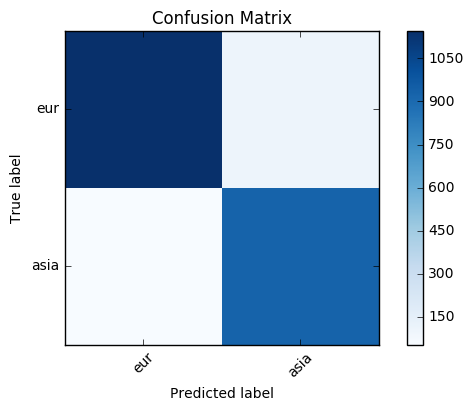

Average accuracy 0.914345407331


In [84]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from  sklearn.metrics import f1_score 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline 
from plotcnf import plot_confusion_matrix
from sklearn.decomposition import PCA

print 'Chance is', max(numpy.bincount(y))/float(len(y))

### added later ### ************************    
foldindices = StratifiedKFold(y)


labels = map(lambda x:x[0], sorted(langgroup_num_map.items(), key=lambda x:x[1]))  
# languages corresponding to class labels as a list

    
k = 70 #num neighbors for kNN

classifiers = [('logreg', LogisticRegression())]  # no knn because it's too slow 
#multi_class='multinomial', 
   

for modelname, model in classifiers:
    for featname, X in [('all', Xall)]:#('time', Xtime), ('code', Xcode), ('all', Xall)]:
        print  'Building a', modelname, 'model with', X.shape[1], featname
    
        cvaccs = numpy.zeros(len(foldindices))
        #cvf1 = numpy.zeros(len(foldindices))
        for i, (trainidx, testidx) in enumerate(foldindices):
            print 'Fold', i+1
        
            ytrain = y[trainidx]
            ytest = y[testidx]
        
            Xtrain = X[trainidx, :]  
            Xtest = X[testidx, :]
            
#             model.fit(Xtrain, ytrain)
#             cvaccs[i] = model.score(Xtest, ytest)

            pca = PCA(n_components=200)

            reduced_train = pca.fit_transform(Xtrain)
            reduced_test = pca.transform(Xtest)
            
            model.fit(reduced_train, ytrain)
            cvaccs[i] = model.score(reduced_test, ytest)
    
        
#             predictions = model.predict(Xtest)
            #cvf1[i] = f1_score(ytest, predictions)
            
            #print '****', modelname, cvaccs[i]
        #analyze last fold only
        cnf_matrix = confusion_matrix(ytest, predictions)  

        plot_confusion_matrix(cnf_matrix, labels)
        plt.show()
        coef = model.coef_
        print 'Average accuracy', numpy.mean(cvaccs)

### Coefs 

In [77]:
sorted(zip(allvec.get_feature_names(), coef[0]), key=lambda tup: tup[1])

[(u'controls_choose', -2.1728149112266033),
 ('TL2', -2.047956608360733),
 (u'TextBox.SetText', -1.5232108220266223),
 (u'OrientationSensor.OrientationChanged', -1.4902367230607341),
 ('NS', -1.4319400244419902),
 (u'Button.Click', -1.373841802384957),
 (u'ListPicker.GetSelection', -1.1655146453290259),
 (u'Label.SetVisible', -1.1566914249656868),
 (u'procedures_defnoreturn', -1.1385645505500135),
 (u'LocationSensor.LocationChanged', -1.0973359746815483),
 (u'Button.LongClick', -1.0895120431817493),
 (u'Clock.GetTimerInterval', -1.0553289227322951),
 (u'text_trim', -1.0349327948545248),
 (u'math_round', -1.0200471814273229),
 (u'color_make_color', -0.99623297148931178),
 (u'None.spaces', -0.98679440918407879),
 (u'procedures_defreturn', -0.98413201868032518),
 (u'math_add', -0.97631318468998196),
 (u'TextBox.SetEnabled', -0.97478486504670148),
 (u'Button.SetBackgroundColor', -0.96296435566730232),
 (u'global_declaration', -0.91793123831947132),
 (u'text_replace_all', -0.903797470157595

In [ ]:
from sklearn.metrics import f1_score
f1_score(ytest, predictions)